## Modeling Approach and Project Trajectory 

1. The Longitudinal nature of the data was not accounted for. This meant removing all ‘baseline’ measures and treating each row as a unique data point. The way we dealt with missing values was imputation with medians, which was mentioned in class as the most effective way of dealing with missingness. The Diagnosis column (DX) was an ordinal variable, and it was accordingly dealt with by mapping values to 0-2. Other categorical variables were one-hot encoded.
2. The next step was to run regressions using each cognitive test as a response variable and the rest of the features (including DX) as predictors. This ensured the we are predicting how well a certain test correlates with the other tests, given the diagnosis. 
3. We then used the R2 scores for each regression to decide which model is the best. Initially we thought that there would be a clear winner both in terms of the diagnostic test as well as the regression model. But on running the models, there were three combinations of test + model that offered comparable performances – ADAS11 (Random Forest), ECogPT (Linear Regression, RidgeCV, and Random Forest) and ECogSP (Linear Regression, RidgeCV, and Random Forest). First we checked the tests for any correlation, since that may have caused the close results. After making a pairplot and heatmap, we realised the tests weren’t sufficiently correlated and we would need to find a way to account for the separate tests. We then decided to create a combined meta-score using these seven test + model predicted scores, weighting each predicted score with the R-squared value, using the following formula:

    **Combined Score = S $R^2$*(Predicted Score)**

    This was a major change in the way we expected to construct the meta-test, and we had to take a decision based on our mathematical understanding of these models about how to weight the score of each test. We were also referencing the literature on Characterizing Alzheimer's disease using a hypometabolic convergence index (HCI), which helped us in formulating our meta-indicator.
 
4. Added the predictions of the best model as a new column(‘meta test’)
5. We then ran a classification using DX values as the classes and the ‘meta test’ as a predictor. Here we ran a number of classification models to determine which gave the best classification accuracy. Out of 4 models (AdaBoost, Logistic Regression, Random Forest Classifier, and Logistic Regression with quadratic terms), Adaboost proved to give the best results. **The classification accuracy rates were .66, .84, and .69 for CN, MCI, and Dementia, respectively. This far out performs a base classifier based on random chance alone.**
6. The results of the classification were then used to show where the classification boundaries are along the scale of the ‘meta test’. While doing this classification, we realised that while our meta-score was reasonably adept at handling the classification of CN and ‘Dementia’, the MCI category was still messy. This meant that there was a lot of ‘bleeding’ into MCI both from the ‘CN’ class and the ‘Dementia’ class. This was problematic, especially on the CN-MCI side, because if a patient actually has MCI and is diagnosed as ‘Cognitively Normal’, no further tests might be conducted. On the Alzheimer’s side, it is still a problem, but the stakes are perhaps not as high. Therefore a need was identified to conducted an additional layer of tests.
7. The range for which MCI was messy was for the meta-test score between 10 and 25. As mentioned, there was considerable bleeding into MCI from both ‘CN’ and ‘Dementia’. We had expected to see some of this on the basis of our initial EDA. We needed to make a decision on how to resolve this issue. The following steps describe the technique we adopted:
  - We queried the full-set for all data-points where our test scored in that range and then re-ran the initial regression to generate an R2 matrix to determine if there were any new tests that performed much better on this filtered range, and indeed ADAS13 emerged as a new test that performed better than other tests specifically on this messy MCI range, and it hadn’t surfaced earlier on the entire dataset.
  - We then reran the classification with Adaboost to see if the MCI class was better classified now, and ADAS13 was indeed showing a better classification accuracy.
  - Based on the ADAS13 score, we were able to identify the second layer of classification categories  (see figure below)
8. We finally generated the dataset with the predicted classifications.


<br/> <br/>
## Implementation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression,LogisticRegressionCV, LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA

%matplotlib inline

First, we have decided to ignore longitudinal data and treat each row as a unique patient. This means we need to take out any 'baseline' data.

In [2]:
df = pd.read_csv('ADNIMERGE.csv')
all_cols = list(df)

# Baseline data is indicated by '_bl' OR described as a baseline measurement in ADNIMERGE_DICT
important_cols = [i for i in all_cols[9:-3] if i[-2:] != 'bl']
important_cols = ['RID'] + important_cols
data = df[important_cols].copy()

`AGE` is probably an important predictor for a diagnosis. However, ADNIMERGE_DICT says that `AGE` is the age of the patient at baseline. Because we are treating each row as a separate patient, we should use `Month_bl` (months from baseline) to calculate a 'new age' for each row. That is, a 65 year old who gets a second exam 12 months later will be treated as a different, 66 year old person.

In [3]:
data['EXACT_AGE'] = df.AGE + (df.Month_bl/12)

In [4]:
# Now we need to one-hot encode the categorical predictors
# BUT since we will eventually do a classification with DX,
# we'll first convert those values and then one-hot encode
# things like marriage, etc

DX_class = []
for i in data.DX.values:
    if i == 'CN':
        DX_class.append(0)
    elif i == 'MCI':
        DX_class.append(1)
    elif i == 'Dementia':
        DX_class.append(2)
    else:
        DX_class.append(i) # for NaNs. will deal with missingness next.

# Now drop the original DX column
data.drop('DX',axis=1,inplace=True)

# and replace with the new DX_class column
data['DX_class'] = DX_class

In [5]:
# get columns with categorical data
# by finding columns that have strings as entries
cat_cols = [i for i in data.columns if isinstance(data[i][0], str)]

# choosing to drop first because that was the 
# suggested best practice in HW3
data_hot = pd.get_dummies(data, columns = cat_cols, drop_first = True)

data_hot.shape

(13017, 54)

Now we need to deal with missingness.

In [6]:
# what percent of each column is missing?
def percent_in_each_col(df):
    percent_missing = [df[i].isnull().mean()*100 for i in list(df)]
    percent_missing = np.asarray(percent_missing)
    in_each = pd.DataFrame(percent_missing,df.columns,columns=["Percent"])
    print(in_each[in_each.Percent > 0])
    print("Average percent missing for all columns: ", in_each[in_each.Percent > 0].mean())

percent_in_each_col(data_hot)

                         Percent
APOE4                   0.453253
FDG                    74.241377
PIB                    98.286856
AV45                   83.398633
CDRSB                  30.736729
ADAS11                 31.174618
ADAS13                 31.835292
MMSE                   29.522932
RAVLT_immediate        30.383345
RAVLT_learning         30.383345
RAVLT_forgetting       30.583084
RAVLT_perc_forgetting  31.120842
FAQ                    29.000538
MOCA                   60.052239
EcogPtMem              59.360836
EcogPtLang             59.483752
EcogPtVisspat          59.798725
EcogPtPlan             59.560575
EcogPtOrgan            60.382577
EcogPtDivatt           59.798725
EcogPtTotal            59.453023
EcogSPMem              59.099639
EcogSPLang             59.061228
EcogSPVisspat          59.829454
EcogSPPlan             59.545210
EcogSPOrgan            60.866559
EcogSPDivatt           60.121380
EcogSPTotal            59.099639
Ventricles             42.790197
Hippocampu

Some of the features have more than 50% of the data missing. This is because some tests were not used during certain protocols (ADNI1 vs ADNIGO, for example). Not sure exactly how to deal with that. Right now, we're just going to impute values for all the missing data, and see where that gets us.

In [7]:
percent_in_each_col(data_hot)

                         Percent
APOE4                   0.453253
FDG                    74.241377
PIB                    98.286856
AV45                   83.398633
CDRSB                  30.736729
ADAS11                 31.174618
ADAS13                 31.835292
MMSE                   29.522932
RAVLT_immediate        30.383345
RAVLT_learning         30.383345
RAVLT_forgetting       30.583084
RAVLT_perc_forgetting  31.120842
FAQ                    29.000538
MOCA                   60.052239
EcogPtMem              59.360836
EcogPtLang             59.483752
EcogPtVisspat          59.798725
EcogPtPlan             59.560575
EcogPtOrgan            60.382577
EcogPtDivatt           59.798725
EcogPtTotal            59.453023
EcogSPMem              59.099639
EcogSPLang             59.061228
EcogSPVisspat          59.829454
EcogSPPlan             59.545210
EcogSPOrgan            60.866559
EcogSPDivatt           60.121380
EcogSPTotal            59.099639
Ventricles             42.790197
Hippocampu

In [8]:
# In lecture, Kevin mentioned that imputing using the median
# will often give you the best results
# so that's the strategy we'll use.

from sklearn.preprocessing import Imputer

imp = Imputer(strategy="median")
imputed = imp.fit_transform(data_hot)
full_data = pd.DataFrame(imputed,columns = data_hot.columns)

percent_in_each_col(full_data)

Empty DataFrame
Columns: [Percent]
Index: []
Average percent missing for all columns:  Percent   NaN
dtype: float64


In [9]:
full_data.head()

,RID,PTEDUCAT,APOE4,FDG,PIB,AV45,CDRSB,ADAS11,ADAS13,MMSE,...,PTRACCAT_Hawaiian/Other PI,PTRACCAT_More than one,PTRACCAT_Unknown,PTRACCAT_White,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Unknown,PTMARRY_Widowed,FLDSTRENG_3 Tesla MRI,FSVERSION_Cross-Sectional FreeSurfer (FreeSurfer Version 4.3)
0,2.0,16.0,0.0,1.36926,1.85,1.11467,0.0,10.67,18.67,28.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,3.0,18.0,1.0,1.09079,1.85,1.11467,4.5,22.00,31.00,20.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,3.0,18.0,1.0,1.06360,1.85,1.11467,6.0,19.00,30.00,24.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,3.0,18.0,1.0,1.10384,1.85,1.11467,3.5,24.00,35.00,17.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,3.0,18.0,1.0,1.03871,1.85,1.11467,8.0,25.67,37.67,19.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


Now, we want to run a few different types of regressions on this 'full' data set using each cognitive test as a response variable. We'll create a matrix of R^2 values, and use that to decide which models should contribute to our 'meta test'.

In [10]:
def split_and_score(df, response_col_name, model):
    # returns TEST score based on model fitted to data with specified response var
    # response_col_name is a string
    # model is an unfitted sklearn model
    # would be nice to add a polynomial features option
    np.random.seed(9001)
    msk = np.random.rand(len(df)) < .75
    
    train = df[msk]
    test = df[~msk]
        
    predictors = [i for i in df.columns[1:] if i not in response_col_name]
    x = train[predictors]
    y = train[response_col_name]
    
    Xt = test[predictors]
    yt = test[response_col_name]        
    
    model.fit(x,y)
    test_score = model.score(Xt, yt)
    return test_score 

In [11]:
def make_score_df(df,response_vars,model_dict):
    # returns a dataframes of TEST r^2 values
    # response_vars is a list of strings
    # model_dict is a dictionary of unfitted sklearn models
    
    keys = list(model_dict.keys())
    scores = np.zeros((len(response_vars),len(keys)))
    
    for col, model in enumerate(keys):
        for row, response in enumerate(response_vars):
            scores[row,col] = split_and_score(df,response,model_dict[model])
   
    score_df = pd.DataFrame(scores,columns=[keys],index=response_vars)

    return score_df

In [12]:
cog_tests = ['ADAS13','CDRSB','MOCA','MMSE','RAVLT_perc_forgetting','FAQ','ADAS11',"EcogPtTotal",'EcogSPTotal']

models = {}
models['KNN'] = KNeighborsRegressor(n_neighbors = 25)
models['LinearRegression'] = LinearRegression(fit_intercept = True)
models['Ridge'] = RidgeCV()
models['Lasso'] = LassoCV()
models['RandomForest'] = RandomForestRegressor()
models['DecisionTree'] = DecisionTreeRegressor()

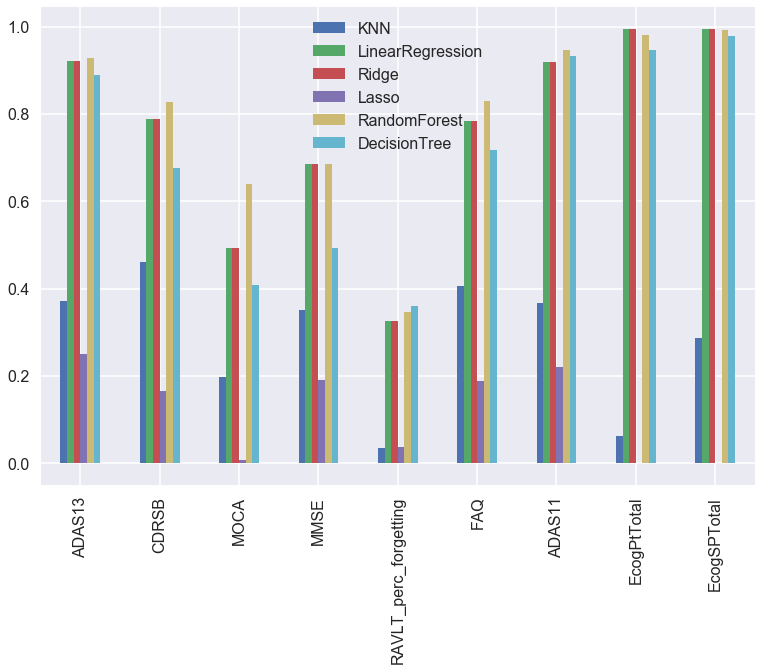

In [13]:
score_df = make_score_df(full_data,cog_tests,models)

sns.set_context("poster")
score_df.plot(kind="bar")

In [14]:
score_df

,KNN,LinearRegression,Ridge,Lasso,RandomForest,DecisionTree
ADAS13,0.370575,0.920684,0.920670,0.249385,0.927926,0.889698
CDRSB,0.461899,0.788965,0.788952,0.165541,0.827817,0.677024
MOCA,0.197120,0.493442,0.493475,0.007704,0.638813,0.408791
MMSE,0.351756,0.684854,0.684950,0.190285,0.686197,0.492026
RAVLT_perc_forgetting,0.035105,0.325546,0.324882,0.036130,0.345215,0.361106
FAQ,0.405214,0.783359,0.783136,0.187249,0.829880,0.716532
ADAS11,0.367270,0.919964,0.920025,0.219364,0.947112,0.933235
EcogPtTotal,0.062392,0.994702,0.994683,-0.000713,0.982113,0.947330
EcogSPTotal,0.287788,0.996034,0.996000,-0.000169,0.992946,0.978392


Now, were are going to combine the test/model pairings with the best $R^2$ scores into one 'meta test'. Those pairings are:

- EcogPtTotal, Linear Regression
- EcogPtTotal, RidgeCV
- EcogPtTotal, RandomForest
- EcogSPTotal, Linear Regression
- EcogSPTotal, RidgeCV
- EcogSPTotal, RandomForest
- ADAS11, RandomForest

We'll refit and predict each model, then create a linear combination of the seven predictions, weighting each by its $R^2$ score.

In [15]:
# create the predictions for each pairing

def create_meta_test(df,model,response):
    # create subset to fit on
    np.random.seed(9001)
    msk = np.random.rand(len(df)) < .5
    small = df[msk]
    
    predictors = [i for i in df.columns[1:] if i not in response]

    x = small[predictors]
    y = small[response]
    
    # set to make the final predictions on
    x_final = df[predictors]
    
    model.fit(x,y)
    meta_test = model.predict(x_final)
    
    return meta_test   

In [16]:
# Use the above function to run regressions on the aforementioned tests
# store the predictions made in a dict that can be turned into a df
tests = ['EcogPtTotal','EcogSPTotal','ADAS11']

meta_models = {}
meta_models["RandomForest"] = RandomForestRegressor()
meta_models["LinearRegression"] = LinearRegression()
meta_models["Ridge"] = RidgeCV()

models = (meta_models.keys())

meta_dict = {}

for m in models:
    for t in tests:
        meta_dict[t+m] = create_meta_test(full_data,meta_models[m],t)

meta_dict.keys()

dict_keys(['EcogPtTotalRandomForest', 'EcogSPTotalRandomForest', 'ADAS11RandomForest', 'EcogPtTotalLinearRegression', 'EcogSPTotalLinearRegression', 'ADAS11LinearRegression', 'EcogPtTotalRidge', 'EcogSPTotalRidge', 'ADAS11Ridge'])

In [17]:
# using a for loop created 2 unwanted predictions, so delete those.
del meta_dict['ADAS11LinearRegression']
del meta_dict['ADAS11Ridge']

In [18]:
# create df of the seven meta tests
meta_tests_df = pd.DataFrame(meta_dict)
meta_tests_df.head()

,ADAS11RandomForest,EcogPtTotalLinearRegression,EcogPtTotalRandomForest,EcogPtTotalRidge,EcogSPTotalLinearRegression,EcogSPTotalRandomForest,EcogSPTotalRidge
0,11.401,1.528085,1.538461,1.531749,1.476596,1.487179,1.491677
1,20.833,1.538620,1.538461,1.541799,1.485760,1.487179,1.499714
2,18.867,1.538584,1.538461,1.541714,1.494279,1.487179,1.508146
3,22.533,1.532685,1.538461,1.535629,1.475840,1.487179,1.489145
4,24.968,1.536617,1.538461,1.539629,1.488639,1.487179,1.502444


In [19]:
# now we'll need to get the R^2s for each pairing to weight the predictions in our linear combination
score_df

,KNN,LinearRegression,Ridge,Lasso,RandomForest,DecisionTree
ADAS13,0.370575,0.920684,0.920670,0.249385,0.927926,0.889698
CDRSB,0.461899,0.788965,0.788952,0.165541,0.827817,0.677024
MOCA,0.197120,0.493442,0.493475,0.007704,0.638813,0.408791
MMSE,0.351756,0.684854,0.684950,0.190285,0.686197,0.492026
RAVLT_perc_forgetting,0.035105,0.325546,0.324882,0.036130,0.345215,0.361106
FAQ,0.405214,0.783359,0.783136,0.187249,0.829880,0.716532
ADAS11,0.367270,0.919964,0.920025,0.219364,0.947112,0.933235
EcogPtTotal,0.062392,0.994702,0.994683,-0.000713,0.982113,0.947330
EcogSPTotal,0.287788,0.996034,0.996000,-0.000169,0.992946,0.978392


In [20]:
# Weighting the predictions
meta_tests_df.ADAS11RandomForest = meta_tests_df.ADAS11RandomForest*score_df.RandomForest[6]
meta_tests_df.EcogPtTotalRandomForest = meta_tests_df.EcogPtTotalRandomForest*score_df.RandomForest[7]
meta_tests_df.EcogSPTotalRandomForest = meta_tests_df.EcogSPTotalRandomForest*score_df.RandomForest[8]

meta_tests_df.EcogPtTotalLinearRegression = meta_tests_df.EcogPtTotalLinearRegression*score_df.LinearRegression[7]
meta_tests_df.EcogSPTotalLinearRegression = meta_tests_df.EcogSPTotalLinearRegression*score_df.LinearRegression[8]

meta_tests_df.EcogPtTotalRidge = meta_tests_df.EcogPtTotalRidge*score_df.Ridge[7]
meta_tests_df.EcogSPTotalRidge = meta_tests_df.EcogSPTotalRidge*score_df.Ridge[8]

In [21]:
# combining the predictions
FinalMetaTest = meta_tests_df.sum(axis=1)

full_data['MetaTest'] = FinalMetaTest

Now, we have a combined meta meta test. Visualize to see how well it separates the true classifications:

In [22]:
meta_dx = full_data[['MetaTest','DX_class']].copy()

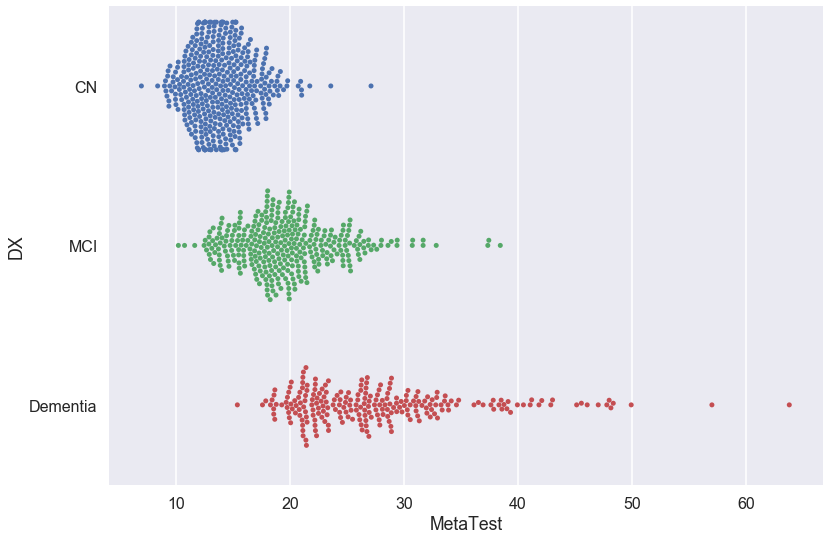

In [23]:
sns.set_context("poster")
# True classifications (DX) plotted against the meta test scores
meta_dx['DX'] = df.DX
sns.swarmplot(x="MetaTest", y="DX", data=meta_dx.head(1000),order=['CN','MCI','Dementia'])


Now see whether we can use some classification models to better separate the classes:

In [24]:
# create df of just meta test and the dx_class
meta_dx = full_data[['MetaTest','DX_class']].copy()

# train test split
np.random.seed(9001)
msk = np.random.rand(len(meta_dx)) < .75
train = meta_dx[msk]
test = meta_dx[~msk]

x = train['MetaTest'].values.reshape(-1,1)
y = train['DX_class']

Xt = test['MetaTest'].values.reshape(-1,1)
yt = test['DX_class']

In [25]:
# Logistic Regression

logit = LogisticRegressionCV(multi_class='multinomial')
logit.fit(x,y)
logit.score(Xt,yt)

0.78347312830071447

In [26]:
# RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x,y)
rfc.score(Xt,yt)

0.70674122398260331

In [27]:
# logistic with quad terms
poly = PolynomialFeatures(degree = 2)
x_poly = poly.fit_transform(x)
Xt_poly = poly.fit_transform(Xt)

log_poly = LogisticRegressionCV(multi_class='multinomial')
log_poly.fit(x_poly,y)
log_poly.score(Xt_poly,yt)

0.78626902764833795

In [28]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier()
ada.fit(x,y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [29]:
from sklearn import metrics
def conf_mat(model,x,y,name):
    # Prints out class accuracies
    # 'model' must be fitted to training data before calling this function
    # x and y should be test
    yp = model.predict(x)
    m = metrics.confusion_matrix(y, yp)
    cn_acc = m[0,0]/np.sum(m[0])
    mci_acc = m[1,1]/np.sum(m[1])
    ad_acc = m[2,2]/np.sum(m[2])
    print(name)
    print("CN Class Accuracy: %f\nMCI Class Accuracy: %f\nAD Class Accuracy: %f\n"%(cn_acc,mci_acc,ad_acc))

In [30]:
# Class accuracies
print("Class accuracies for each classifier:")
conf_mat(ada,Xt,yt,"Ada")
conf_mat(logit,Xt,yt,"Logistic Regression")
conf_mat(rfc,Xt,yt,"Random Forest")
conf_mat(log_poly,Xt_poly,yt,"Logistic Regression with Quad Terms")

Class accuracies for each classifier:
Ada
CN Class Accuracy: 0.659259
MCI Class Accuracy: 0.844433
AD Class Accuracy: 0.687970

Logistic Regression
CN Class Accuracy: 0.534815
MCI Class Accuracy: 0.897117
AD Class Accuracy: 0.669173

Random Forest
CN Class Accuracy: 0.583704
MCI Class Accuracy: 0.773360
AD Class Accuracy: 0.610902

Logistic Regression with Quad Terms
CN Class Accuracy: 0.562963
MCI Class Accuracy: 0.896123
AD Class Accuracy: 0.654135



It looks like AdaBoost is the best overall classifier, especially with CN and AD (Dementia). We'll now make predictions using the AdaBoost classifier and see how it performs compared to the true classifications.

In [31]:
# create predictions
dx_preds = ada.predict(meta_dx.MetaTest.values.reshape(-1,1))
meta_dx['Preds'] = dx_preds

In [32]:
# convert prediction class numbers into strings so we can visualize
pred_class=[]
for i in meta_dx.Preds.values:
    if i == 0:
        pred_class.append('CN')
    elif i == 1:
        pred_class.append('MCI')
    elif i == 2:
        pred_class.append('Dementia')

meta_dx['Preds'] = pred_class

In [33]:
sns.set_context("poster")

In [34]:
# bring back the original DX column so we can compare AdaBoost to actual classifications
meta_dx['DX'] = df.DX

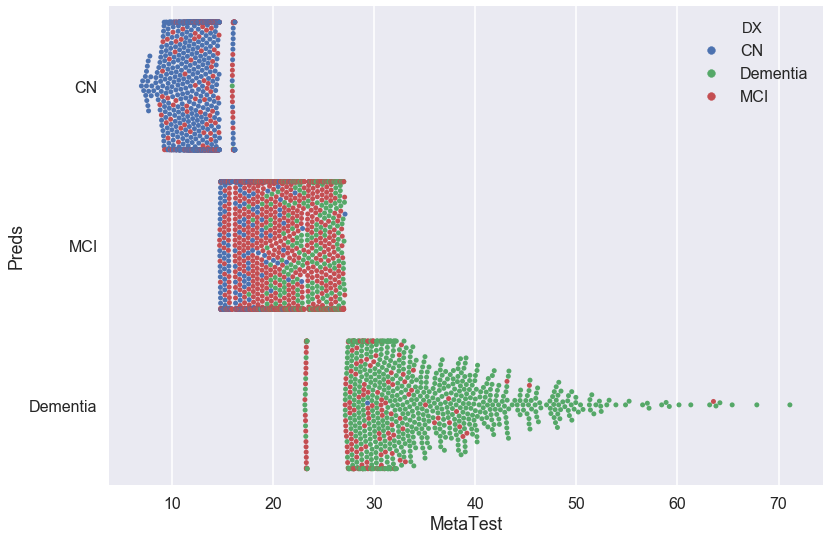

In [35]:
sns.swarmplot(x="MetaTest", y="Preds",hue="DX", data=meta_dx.head(5000),order=['CN','MCI','Dementia'])

Here, we see that the AdaBoost classifier paired with the Meta Test does a good job separating CN from Dementia, but a bad job separating MCI from either. Below a score of 10 on the Meta Test, most patients are correctly classified as CN, and above a score of 25, most patients are correctly classified as having Dementia.

To deal with this, we will identify an existing cognitive test that separates MCI *better* than our meta test for those patients who score *between 10 and 25* on the meta test.

In [36]:
# look at patients who score between 10 and 25 on the meta test
mci_df = full_data[full_data.MetaTest > 10]
mci_df = mci_df[mci_df.MetaTest < 25]
mci_df.head()

,RID,PTEDUCAT,APOE4,FDG,PIB,AV45,CDRSB,ADAS11,ADAS13,MMSE,...,PTRACCAT_More than one,PTRACCAT_Unknown,PTRACCAT_White,PTMARRY_Married,PTMARRY_Never married,PTMARRY_Unknown,PTMARRY_Widowed,FLDSTRENG_3 Tesla MRI,FSVERSION_Cross-Sectional FreeSurfer (FreeSurfer Version 4.3),MetaTest
0,2.0,16.0,0.0,1.36926,1.85,1.11467,0.0,10.67,18.67,28.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,19.785698
5,4.0,10.0,0.0,1.21987,1.85,1.11467,1.0,14.33,21.33,27.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,22.530958
6,4.0,10.0,0.0,1.21987,1.85,1.11467,0.5,17.33,25.33,28.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,24.628533
7,4.0,10.0,0.0,1.21987,1.85,1.11467,1.0,15.00,22.00,26.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,21.517971
10,5.0,16.0,0.0,1.29799,1.85,1.11467,0.0,8.67,14.67,29.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,16.150568


In [37]:
# re run the model comparisons to see which test has the best R2
cog_tests = ['ADAS13','CDRSB','MOCA','MMSE','RAVLT_perc_forgetting','FAQ','ADAS11',"EcogPtTotal",'EcogSPTotal']

models = {}
models['KNN'] = KNeighborsRegressor(n_neighbors = 25)
models['LinearRegression'] = LinearRegression(fit_intercept = True)
models['Ridge'] = RidgeCV()
models['Lasso'] = LassoCV()
models['RandomForest'] = RandomForestRegressor()
models['DecisionTree'] = DecisionTreeRegressor()

mci_r2 = make_score_df(mci_df,cog_tests,models)
mci_r2

,KNN,LinearRegression,Ridge,Lasso,RandomForest,DecisionTree
ADAS13,0.230274,0.956446,0.956453,0.189939,0.935971,0.881976
CDRSB,0.378912,0.689830,0.689791,0.067439,0.695157,0.466489
MOCA,0.155813,0.325078,0.324694,0.061604,0.428909,-0.103697
MMSE,0.102053,0.419381,0.421212,0.117724,0.378635,-0.153016
RAVLT_perc_forgetting,0.157694,0.774492,0.774062,0.059336,0.933498,0.880890
FAQ,0.260980,0.693823,0.693576,0.058488,0.711456,0.444634
ADAS11,0.190480,0.889672,0.889595,0.151635,0.865775,0.774728
EcogPtTotal,0.044449,0.997780,0.997748,-0.001345,0.981324,0.917421
EcogSPTotal,0.247359,0.994470,0.993791,0.011690,0.983337,0.947220


It is clear here that ADAS13 has suddenly become very good in this range, while ADAS11 has dropped its $R^2$. We'll focus on ADAS13 to see if it separates MCI better. 

In [38]:
np.random.seed(9001)
msk = np.random.rand(len(mci_df)) < .75
train2 = mci_df[msk]
test2 = mci_df[~msk]

x2 = train2['ADAS13'].values.reshape(-1,1)
y2 = train2['DX_class']

Xt2 = test2['ADAS13'].values.reshape(-1,1)
yt2 = test2['DX_class']

In [39]:
ada.fit(x2,y2)
conf_mat(ada,Xt2,yt2,"Ada")

Ada
CN Class Accuracy: 0.742089
MCI Class Accuracy: 0.843459
AD Class Accuracy: 0.000000



Now we'll repeat the above process to see how well the AdaBoost Classifier on the ADAS13 test performs.

In [40]:
mci_preds = ada.predict(mci_df.ADAS13.values.reshape(-1,1))

In [41]:
mci_df['ADAS13Preds'] = mci_preds
pred_class=[]
for i in mci_df.ADAS13Preds.values:
    if i == 0:
        pred_class.append('CN')
    elif i == 1:
        pred_class.append('MCI')
    elif i == 2:
        pred_class.append('Dementia')
mci_df['ADAS13Preds'] = pred_class

In [42]:
pred_class=[]
for i in mci_df.DX_class.values:
    if i == 0:
        pred_class.append('CN')
    elif i == 1:
        pred_class.append('MCI')
    elif i == 2:
        pred_class.append('Dementia')
mci_df['DX_class'] = pred_class

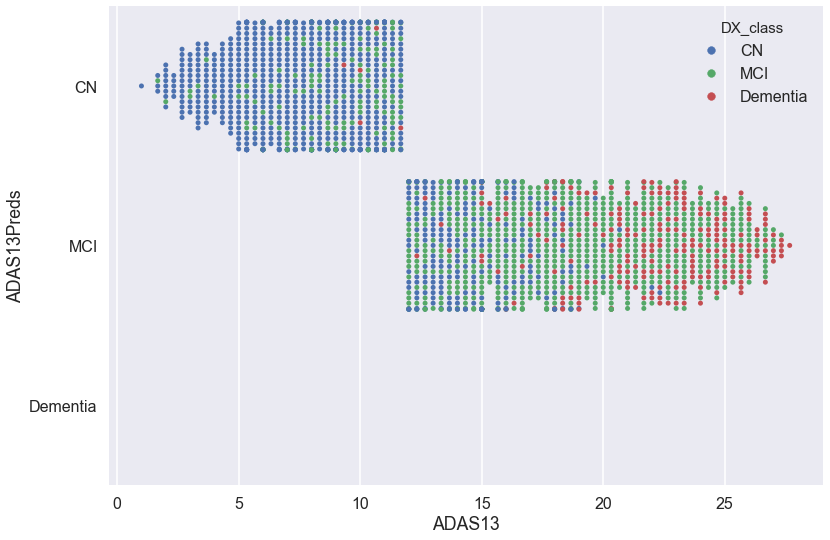

In [43]:
sns.swarmplot(x="ADAS13", y="ADAS13Preds",hue="DX_class", data=mci_df.head(2000),order=['CN','MCI','Dementia'])

Here we can see that the AdaBoost on the ADAS13 does a good job of separating MCI and CN. This means that we should use ADAS13 as a secondary test when patients score between 10 and 25 on our meta test.